(20000, 28, 28)
(5000, 28, 28)


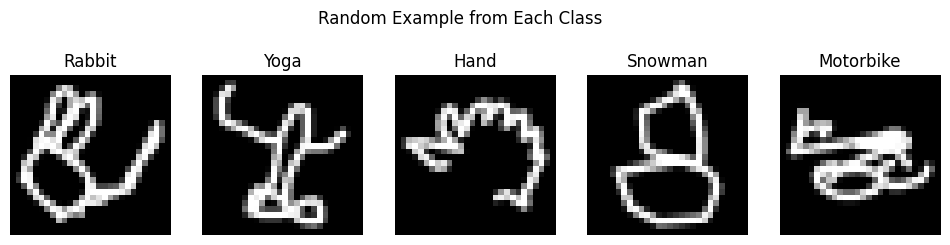

Training Set Class Counts:
Rabbit    : 4000
Yoga      : 4000
Hand      : 4000
Snowman   : 4000
Motorbike : 4000

Test Set Class Counts:
Rabbit    : 1000
Yoga      : 1000
Hand      : 1000
Snowman   : 1000
Motorbike : 1000
(20000, 588)
(5000, 588)


In [1]:
import numpy as np
from skimage.feature import hog
from skimage.filters import sobel
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score

train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)

## Labels

## The integer labels correspond to the following classes:
## - 0: rabbit
## - 1: yoga
## - 2: hand
## - 3: snowman
## - 4: motorbike

class_names = ['Rabbit', 'Yoga', 'Hand', 'Snowman', 'Motorbike']

plt.figure(figsize=(12, 3))
for class_id in range(5):
    indices = np.where(train_labels == class_id)[0]
    random_idx = np.random.choice(indices)
    plt.subplot(1, 5, class_id + 1)
    plt.imshow(train_images[random_idx], cmap='gray')
    plt.title(f"{class_names[class_id]}")
    plt.axis('off')
plt.suptitle("Random Example from Each Class")
plt.show()

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("Training Set Class Counts:")
for i in range(5):
    print(f"{class_names[i]:<10}: {train_counts[i]}")

print("\nTest Set Class Counts:")
for i in range(5):
    print(f"{class_names[i]:<10}: {test_counts[i]}")

def extract_features(images):
    features = []
    for img in images:
        # hog features
        hog_features = hog(img, orientations=12, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=False, feature_vector=True)
        features.append(hog_features)

    return np.array(features)

train_features = extract_features(train_images)
test_features = extract_features(test_images)

print(train_features.shape)
print(test_features.shape)

In [3]:
def kmeans(X, k=5, max_iters=100, tol=1e-4, distance='euclidean'):
    np.random.seed(42)
    n_samples, n_features = X.shape
    # Random initialization
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[indices]

    for _ in range(max_iters):
        distances = cdist(X, centroids, metric=distance)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == j].mean(axis=0) if len(X[labels == j]) > 0 else centroids[j]
                                  for j in range(k)])

        # Stop if centroids do not change much
        if np.linalg.norm(centroids - new_centroids) < tol:
            break

        centroids = new_centroids

    return labels, centroids

def compute_sse(X, labels, centroids):
    sse = 0.0
    for i, center in enumerate(centroids):
        cluster_points = X[labels == i]
        sse += np.sum((cluster_points - center) ** 2)
    return sse

def clustering_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    cost_matrix = np.zeros((D, D), dtype=int)
    for i in range(len(y_pred)):
        cost_matrix[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    return sum(cost_matrix[row, col] for row, col in zip(row_ind, col_ind)) / len(y_true)

def evaluate_clustering(X, y_true, y_pred, centroids):
    sse = compute_sse(X, y_pred, centroids)
    acc = clustering_accuracy(y_true, y_pred)
    silhouette = silhouette_score(X, y_pred)
    ch_score = calinski_harabasz_score(X, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    return {
        "SSE": sse,
        "Accuracy": acc,
        "Silhouette Score": silhouette,
        "Calinski-Harabasz": ch_score,
        "ARI": ari,
        "NMI": nmi
    }

In [4]:
results = {}

for dist in ['euclidean', 'cityblock', 'cosine']:
    print(f"Clustering with {dist} distance...")
    labels, centers = kmeans(train_features, k=5, distance=dist)
    metrics = evaluate_clustering(train_features, train_labels, labels, centers)
    results[dist] = metrics
    for key, val in metrics.items():
        print(f"{key}: {val:.4f}")
    print("-" * 40)

Clustering with euclidean distance...
SSE: 400211.1839
Accuracy: 0.5040
Silhouette Score: 0.0385
Calinski-Harabasz: 604.9172
ARI: 0.2375
NMI: 0.2815
----------------------------------------
Clustering with cityblock distance...
SSE: 410055.2370
Accuracy: 0.5048
Silhouette Score: 0.0529
Calinski-Harabasz: 470.3919
ARI: 0.2069
NMI: 0.3097
----------------------------------------
Clustering with cosine distance...
SSE: 400436.0225
Accuracy: 0.5089
Silhouette Score: 0.0391
Calinski-Harabasz: 601.7708
ARI: 0.2440
NMI: 0.2852
----------------------------------------
